In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

import random 

import yfinance as yf
from yahooquery import Ticker
from yahooquery import Screener

from sklearn.metrics import mean_squared_error as mse

from sklearn.model_selection import train_test_split

import xgboost as xgb

from utils import *

from sklearn.preprocessing import MinMaxScaler, RobustScaler


C:\ML\kaggle\kaggle_competition\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class CFG:
    data_path = "../data"
    img_dim1 = 20
    img_dim2 = 10
    nepochs = 6
    seed = 42
    EPOCH = 300
    bsize = 16
    BATCH_SIZE = 1024


# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   


def seed_everything(seed: int = 42) -> None:
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seed_everything(CFG.seed)

In [3]:
START_DATE = '2017-01-01'
END_DATE = '2023-01-01'

nq = yf.download(tickers = "^IXIC",  
                    start=START_DATE, 
                    end=END_DATE)

dji = yf.download(tickers = "^DJI",  
                    start=START_DATE, 
                    end=END_DATE)

spx = yf.download(tickers = "^SPX",  
                    start=START_DATE, 
                    end=END_DATE)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
merged_df_dict = {
                  'Date': np.array(nq.index), 
                  'IXIC': np.array(nq.Close.values), 
                  'SPX': np.array(spx.Close.values), 
                  'DJI': np.array(dji.Close.values)
                  }

merged_df_index = nq.index

merged_df = pd.DataFrame(data=merged_df_dict, index=merged_df_index, columns=['Date', 'IXIC', 'SPX', 'DJI'])

In [6]:
xgb_predictions_n_errors = pd.DataFrame(
                                        data=None,
                                        index=None,
                                        columns=['1_day', '5_days', '10_days', '1_month', '2_months', '6_months', '1_year']
                                        )

xgb_predictions_n_errors['Dataset'] = ['IXIC', 'IXIC', 'IXIC', 'DJI', 'DJI', 'DJI', 'SPX', 'SPX', 'SPX']
xgb_predictions_n_errors['Metric'] = ['RMSE', 'MAE', 'MAPE', 'RMSE', 'MAE', 'MAPE', 'RMSE', 'MAE', 'MAPE']

xgb_predictions_n_errors.set_index(['Dataset', 'Metric'], inplace=True)

In [7]:
xgb_predictions_n_errors

1_day 5_days 10_days 1_month 2_months 6_months 1_year
Dataset Metric                                                      
IXIC    RMSE     NaN    NaN     NaN     NaN      NaN      NaN    NaN
        MAE      NaN    NaN     NaN     NaN      NaN      NaN    NaN
        MAPE     NaN    NaN     NaN     NaN      NaN      NaN    NaN
DJI     RMSE     NaN    NaN     NaN     NaN      NaN      NaN    NaN
        MAE      NaN    NaN     NaN     NaN      NaN      NaN    NaN
        MAPE     NaN    NaN     NaN     NaN      NaN      NaN    NaN
SPX     RMSE     NaN    NaN     NaN     NaN      NaN      NaN    NaN
        MAE      NaN    NaN     NaN     NaN      NaN      NaN    NaN
        MAPE     NaN    NaN     NaN     NaN      NaN      NaN    NaN

In [36]:
def xgb_pipe(lookback_horizon, save_dir, model_str, xgb_predictions_n_errors):

        for dataset in set(xgb_predictions_n_errors.index.get_level_values(0)):

                df = merged_df[['Date', dataset]].copy()
                df['Date'] = pd.to_datetime(df['Date'])
                df.set_index('Date', inplace=True)

                scaler = MinMaxScaler()
                df = scaler.fit_transform(df)
        
                for pred_horizon, horizon_string in [[1, '1_day'], [5, '5_days'], [10, '10_days'], [30, '1_month']]:

                        look_back = lookback_horizon
                        look_ahead = pred_horizon

                        xdat, ydat = create_dataset(
                                                df,
                                                look_back = look_back,
                                                look_ahead = look_ahead
                                                )

                        # [batch size, time steps, dimensionality]
                        xtrain, ytrain, xvalid, yvalid = prepare_split(
                                                                xdat,
                                                                ydat,
                                                                cutoff = int(len(xdat) * 0.8),
                                                                timesteps = look_back
                                                                )
                        print(f"train before {xtrain.shape}")
                        xtrain.shape = xtrain.shape[0], xtrain.shape[1]
                        xvalid.shape = xvalid.shape[0], xvalid.shape[1]
                        print(f"train after {xtrain.shape}")
                        reg = xgb.XGBRegressor(
                                n_estimators=1000,
                                eta=0.05
                                )

                        reg.fit(
                                xtrain, ytrain,
                                eval_set=[(xtrain, ytrain), (xvalid, yvalid)],
                                eval_metric='logloss',
                                early_stopping_rounds=50,
                                verbose=100
                        )

                        y_pred = reg.predict(xvalid)
                        print(f"Prediction {y_pred.shape}")
                        print(f"Valid {yvalid.shape}")

                        if pred_horizon == 1:
                                y_pred = y_pred.reshape(-1, 1)
                                
                        y_pred = scaler.inverse_transform(y_pred)
                        yvalid = scaler.inverse_transform(yvalid)
                        # print(f"Valid {yvalid[:20]}")

                        if pred_horizon == 1:
                                plt.plot(yvalid, label="True")
                                plt.plot(y_pred, label="Forecast")
                        else:

                                # plt.plot([item[0] for item in yvalid], label="True")
                                plt.plot([item[0] for item in yvalid], label="True")
                                # plt.plot([item.mean() for item in y_pred], label="Forecast")
                                # plt.plot([item[0] for item in y_pred], label="Forecast")
                                plt.plot([item[0] for item in y_pred], label="Forecast")
                        plt.legend()
                        plt.savefig(
                                        f"{CFG.data_path}/{save_dir}/{model_str}/{model_str}_{dataset}_{horizon_string}.jpg", 
                                        bbox_inches='tight', dpi=120
                                        )
                        plt.clf()

                        xgb_predictions_n_errors = assign_values(xgb_predictions_n_errors,
                                                                        dataset,
                                                                        y_pred,
                                                                        yvalid,
                                                                        horizon_string)

        xgb_predictions_n_errors.to_csv(f"{CFG.data_path}/{save_dir}/{model_str}/{model_str}_{save_dir}_window_errors.csv")
# y_pred5 = model5.predict(xvalid)
# y_pred5 = scaler.inverse_transform(y_pred5)

In [17]:
xgb_pipe(20, '20d', 'xgb', xgb_predictions_n_errors)

[0]	validation_0-logloss:0.67691	validation_1-logloss:0.67808


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.50461	validation_1-logloss:0.50668
[200]	validation_0-logloss:0.50450	validation_1-logloss:0.50598
[300]	validation_0-logloss:0.50448	validation_1-logloss:0.50576
[400]	validation_0-logloss:0.50447	validation_1-logloss:0.50573
[405]	validation_0-logloss:0.50447	validation_1-logloss:0.50574
(298,)
(298, 1)
[0]	validation_0-logloss:0.67700	validation_1-logloss:0.67787


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.50557	validation_1-logloss:0.51293
[200]	validation_0-logloss:0.50538	validation_1-logloss:0.51248
[300]	validation_0-logloss:0.50533	validation_1-logloss:0.51232
[400]	validation_0-logloss:0.50532	validation_1-logloss:0.51227
[452]	validation_0-logloss:0.50531	validation_1-logloss:0.51227
(297, 5)
(1485, 1)
[0]	validation_0-logloss:0.67712	validation_1-logloss:0.67762


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.50669	validation_1-logloss:0.51563
[200]	validation_0-logloss:0.50643	validation_1-logloss:0.51539
[300]	validation_0-logloss:0.50637	validation_1-logloss:0.51535
[400]	validation_0-logloss:0.50635	validation_1-logloss:0.51534
[432]	validation_0-logloss:0.50634	validation_1-logloss:0.51535
(296, 10)
(2960, 1)
[0]	validation_0-logloss:0.67747	validation_1-logloss:0.67687


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.51007	validation_1-logloss:0.51699
[117]	validation_0-logloss:0.50994	validation_1-logloss:0.51704
(292, 30)
(8760, 1)
[0]	validation_0-logloss:0.68334	validation_1-logloss:0.67313


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.58055	validation_1-logloss:0.45474
[200]	validation_0-logloss:0.58044	validation_1-logloss:0.45447
[300]	validation_0-logloss:0.58041	validation_1-logloss:0.45441
[395]	validation_0-logloss:0.58040	validation_1-logloss:0.45439
(298,)
(298, 1)
[0]	validation_0-logloss:0.68347	validation_1-logloss:0.67296


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.58151	validation_1-logloss:0.46089
[200]	validation_0-logloss:0.58130	validation_1-logloss:0.46087
[286]	validation_0-logloss:0.58125	validation_1-logloss:0.46088
(297, 5)
(1485, 1)
[0]	validation_0-logloss:0.68361	validation_1-logloss:0.67273


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.58265	validation_1-logloss:0.46713
[139]	validation_0-logloss:0.58246	validation_1-logloss:0.46719
(296, 10)
(2960, 1)
[0]	validation_0-logloss:0.68400	validation_1-logloss:0.67281


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[93]	validation_0-logloss:0.58615	validation_1-logloss:0.48999
(292, 30)
(8760, 1)
[0]	validation_0-logloss:0.67535	validation_1-logloss:0.68193


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.48614	validation_1-logloss:0.55386
[200]	validation_0-logloss:0.48607	validation_1-logloss:0.55348
[300]	validation_0-logloss:0.48605	validation_1-logloss:0.55346
[308]	validation_0-logloss:0.48605	validation_1-logloss:0.55346
(298,)
(298, 1)
[0]	validation_0-logloss:0.67543	validation_1-logloss:0.68163


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.48702	validation_1-logloss:0.55801
[200]	validation_0-logloss:0.48690	validation_1-logloss:0.55780
[231]	validation_0-logloss:0.48689	validation_1-logloss:0.55781
(297, 5)
(1485, 1)
[0]	validation_0-logloss:0.67552	validation_1-logloss:0.68136


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.48809	validation_1-logloss:0.55844
[200]	validation_0-logloss:0.48793	validation_1-logloss:0.55825
[300]	validation_0-logloss:0.48789	validation_1-logloss:0.55824
[364]	validation_0-logloss:0.48788	validation_1-logloss:0.55823
(296, 10)
(2960, 1)
[0]	validation_0-logloss:0.67582	validation_1-logloss:0.68030


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.49156	validation_1-logloss:0.56258
[107]	validation_0-logloss:0.49152	validation_1-logloss:0.56273
(292, 30)
(8760, 1)


<Figure size 1440x720 with 0 Axes>

In [18]:
xgb_pipe(50, '50d', 'xgb', xgb_predictions_n_errors)

[0]	validation_0-logloss:0.67745	validation_1-logloss:0.67803


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.51196	validation_1-logloss:0.50742
[200]	validation_0-logloss:0.51186	validation_1-logloss:0.50704
[300]	validation_0-logloss:0.51184	validation_1-logloss:0.50694
[400]	validation_0-logloss:0.51183	validation_1-logloss:0.50689
[447]	validation_0-logloss:0.51183	validation_1-logloss:0.50689
(292,)
(292, 1)
[0]	validation_0-logloss:0.67754	validation_1-logloss:0.67789


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.51274	validation_1-logloss:0.51437
[200]	validation_0-logloss:0.51259	validation_1-logloss:0.51430
[300]	validation_0-logloss:0.51257	validation_1-logloss:0.51427
[400]	validation_0-logloss:0.51256	validation_1-logloss:0.51424
[452]	validation_0-logloss:0.51256	validation_1-logloss:0.51424
(291, 5)
(1455, 1)
[0]	validation_0-logloss:0.67765	validation_1-logloss:0.67736


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.51375	validation_1-logloss:0.52155
[117]	validation_0-logloss:0.51368	validation_1-logloss:0.52189
(290, 10)
(2900, 1)
[0]	validation_0-logloss:0.67799	validation_1-logloss:0.67584


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[89]	validation_0-logloss:0.51742	validation_1-logloss:0.53192
(286, 30)
(8580, 1)
[0]	validation_0-logloss:0.68371	validation_1-logloss:0.67310


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.58471	validation_1-logloss:0.46045
[200]	validation_0-logloss:0.58460	validation_1-logloss:0.46021
[240]	validation_0-logloss:0.58459	validation_1-logloss:0.46023
(292,)
(292, 1)
[0]	validation_0-logloss:0.68382	validation_1-logloss:0.67300


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.58544	validation_1-logloss:0.46657
[122]	validation_0-logloss:0.58537	validation_1-logloss:0.46661
(291, 5)
(1455, 1)
[0]	validation_0-logloss:0.68394	validation_1-logloss:0.67264


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.58644	validation_1-logloss:0.47277
[110]	validation_0-logloss:0.58638	validation_1-logloss:0.47289
(290, 10)
(2900, 1)


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.68434	validation_1-logloss:0.67256
[89]	validation_0-logloss:0.59015	validation_1-logloss:0.49339
(286, 30)
(8580, 1)
[0]	validation_0-logloss:0.67587	validation_1-logloss:0.68208


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.49347	validation_1-logloss:0.55932
[200]	validation_0-logloss:0.49340	validation_1-logloss:0.55871
[300]	validation_0-logloss:0.49339	validation_1-logloss:0.55861
[400]	validation_0-logloss:0.49339	validation_1-logloss:0.55859
[432]	validation_0-logloss:0.49339	validation_1-logloss:0.55859
(292,)
(292, 1)
[0]	validation_0-logloss:0.67595	validation_1-logloss:0.68196


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.49429	validation_1-logloss:0.56434
[200]	validation_0-logloss:0.49420	validation_1-logloss:0.56429
(291, 5)
(1455, 1)
[0]	validation_0-logloss:0.67604	validation_1-logloss:0.68169


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.49532	validation_1-logloss:0.56619
[119]	validation_0-logloss:0.49527	validation_1-logloss:0.56638
(290, 10)
(2900, 1)


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.67635	validation_1-logloss:0.68044
[88]	validation_0-logloss:0.49901	validation_1-logloss:0.57575
(286, 30)
(8580, 1)


<Figure size 1440x720 with 0 Axes>

In [19]:
xgb_pipe(80, '80d', 'xgb', xgb_predictions_n_errors)

[0]	validation_0-logloss:0.67796	validation_1-logloss:0.67763


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.51870	validation_1-logloss:0.51834
[104]	validation_0-logloss:0.51869	validation_1-logloss:0.51858
(286,)
(286, 1)
[0]	validation_0-logloss:0.67805	validation_1-logloss:0.67710


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[91]	validation_0-logloss:0.51963	validation_1-logloss:0.53447
(285, 5)
(1425, 1)
[0]	validation_0-logloss:0.67817	validation_1-logloss:0.67617


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[84]	validation_0-logloss:0.52081	validation_1-logloss:0.54843
(284, 10)
(2840, 1)


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.67851	validation_1-logloss:0.67549
[79]	validation_0-logloss:0.52462	validation_1-logloss:0.55187
(280, 30)
(8400, 1)
[0]	validation_0-logloss:0.68404	validation_1-logloss:0.67337


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.58833	validation_1-logloss:0.46843
[113]	validation_0-logloss:0.58829	validation_1-logloss:0.46873
(286,)
(286, 1)
[0]	validation_0-logloss:0.68415	validation_1-logloss:0.67285


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[97]	validation_0-logloss:0.58917	validation_1-logloss:0.48028
(285, 5)
(1425, 1)
[0]	validation_0-logloss:0.68428	validation_1-logloss:0.67249


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[92]	validation_0-logloss:0.59028	validation_1-logloss:0.48566
(284, 10)
(2840, 1)


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.68468	validation_1-logloss:0.67202
[86]	validation_0-logloss:0.59415	validation_1-logloss:0.50379
(280, 30)
(8400, 1)
[0]	validation_0-logloss:0.67633	validation_1-logloss:0.68253


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.49960	validation_1-logloss:0.56570
[129]	validation_0-logloss:0.49955	validation_1-logloss:0.56580
(286,)
(286, 1)
[0]	validation_0-logloss:0.67642	validation_1-logloss:0.68216


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.50049	validation_1-logloss:0.57826
[104]	validation_0-logloss:0.50048	validation_1-logloss:0.57836
(285, 5)
(1425, 1)
[0]	validation_0-logloss:0.67652	validation_1-logloss:0.68181


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[92]	validation_0-logloss:0.50168	validation_1-logloss:0.58393
(284, 10)
(2840, 1)


C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ML\kaggle\kaggle_competition\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.67683	validation_1-logloss:0.68044
[78]	validation_0-logloss:0.50551	validation_1-logloss:0.60301
(280, 30)
(8400, 1)


<Figure size 1440x720 with 0 Axes>

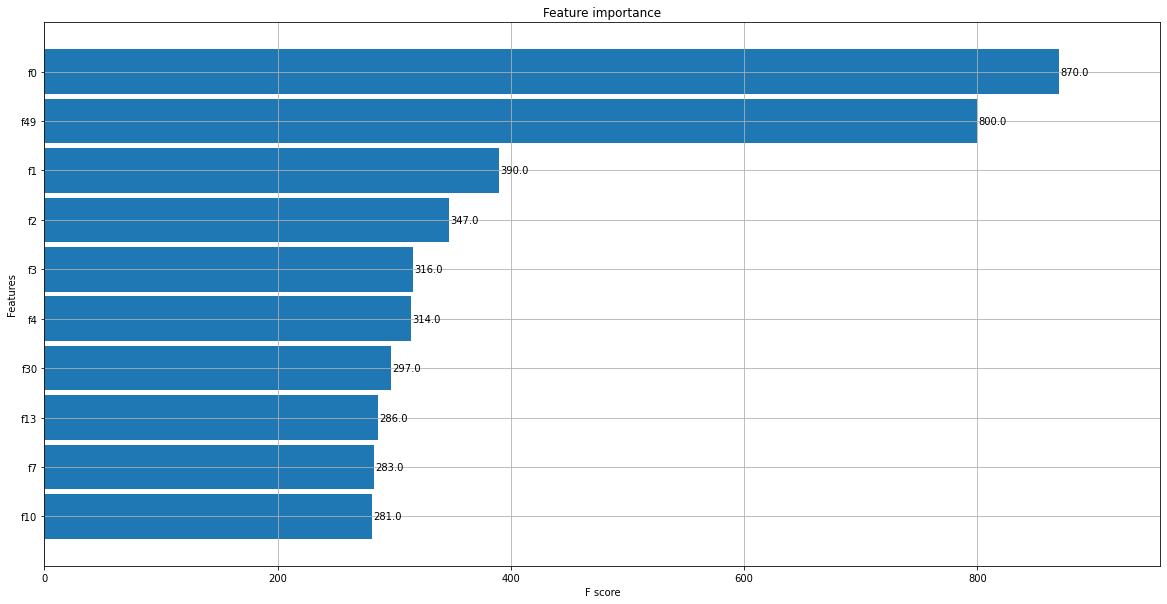

In [528]:
from xgboost import plot_importance, plot_tree

_ = plot_importance(reg, height=0.9 ,max_num_features = 10)

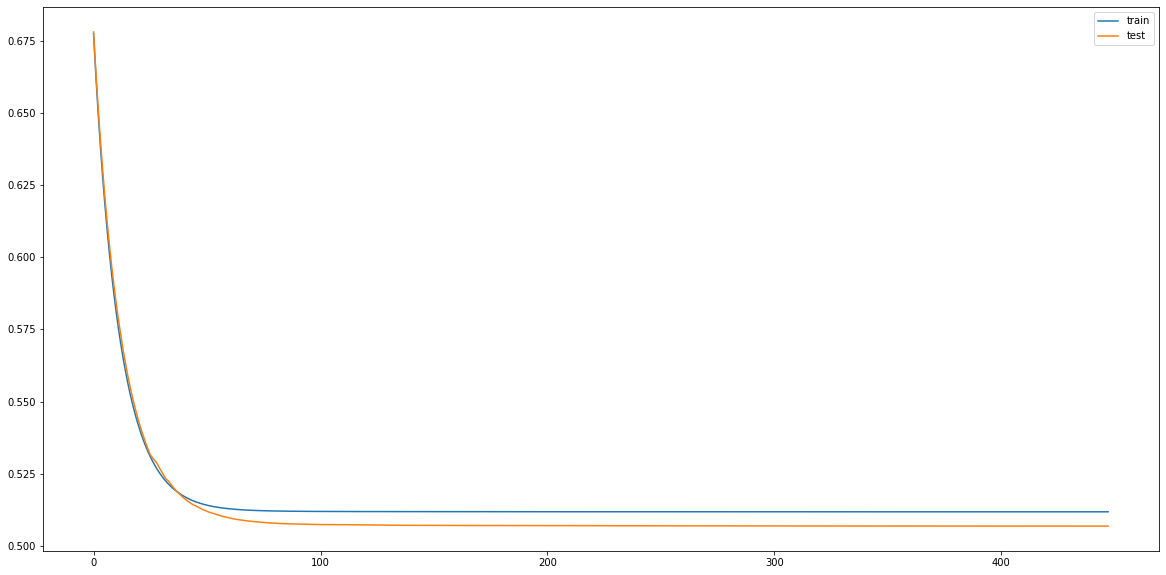

In [527]:
# retrieve performance metrics
results = reg.evals_result()


plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()